<a href="https://colab.research.google.com/github/jianlgler/IST_labiagi/blob/main/PyTorch_AdaIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

from tqdm.notebook import tqdm
from google.colab import drive
import numpy as np
import os
import sys

from PIL import Image
import matplotlib.pyplot as plt

manualSeed = 999
torch.manual_seed(manualSeed)

drive.mount("/content/data", force_remount = True)
path = "/content/data/MyDrive/images"


sys.path.append(path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Exception in thread Thread-19:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/summary/writer/event_file_writer.py", line 247, in run
    self._record_writer.flush()
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/summary/writer/record_writer.py", line 43, in flush
    self._writer.flush()
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/lib/io/file_io.py", line 219, in flush
    self._writable_file.flush()
tensorflow.python.framework.errors_impl.FailedPreconditionError: /content/data/MyDrive/runs/Run 1/events.out.tfevents.1661771009.d84e3f72f31f.67.5; Transport endpoint is not connected



Mounted at /content/data


In [32]:
imsize = (512, 512) if torch.cuda.is_available() else (128, 128)  # use small size if no gpu

loader = transforms.Compose([transforms.Resize(imsize),  transforms.ToTensor()])  # transform it into a torch tensor
unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
  image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
  image = tensor.squeeze(0)      # remove the fake batch dimension
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
      plt.title(title)
  plt.pause(0.001) # pause a bit so that plots are updated

pathStyleImages = "/content/data/MyDrive/images/style"
pathContentImages = "/content/data/MyDrive/images/content" 

class Images(Dataset): 
  def __init__(self, root_dir1, root_dir2, transforms=None):
    self.root_dir1 = root_dir1
    self.root_dir2 = root_dir2
    self.transforms = transforms

  def __len__(self):
    return min(len(os.listdir(self.root_dir1)), len(os.listdir(self.root_dir2))) #?????????????????????????

  def __getitem__(self, idx):
    all_names1, all_names2 = os.listdir(self.root_dir1), os.listdir(self.root_dir2)

    assert (idx < len(all_names1) and len(all_names2))

    img_name1, img_name2 = os.path.join(self.root_dir1, all_names1[idx]), os.path.join(self.root_dir2, all_names2[idx])
    image1 = Image.open(img_name1).convert("RGB")
    image2 = Image.open(img_name2).convert("RGB")

    if self.transforms:
      image1 = self.transforms(image1)
      image2 = self.transforms(image2)

    return image1, image2

  def __getrandomitem__(self):
    all_names1, all_names2 = os.listdir(self.root_dir1), os.listdir(self.root_dir2)
    idx1, idx2 = np.random.randint(0, len(all_names1)), np.random.randint(0, len(all_names2))

    img_name1, img_name2 = os.path.join(self.root_dir1, all_names1[idx1]), os.path.join(self.root_dir2, all_names2[idx2])
    image1 = Image.open(img_name1).convert("RGB")
    image2 = Image.open(img_name2).convert("RGB")

    if self.transforms:
      image1 = self.transforms(image1)
      image2 = self.transforms(image2)

    return image1, image2

all_img = Images(pathStyleImages, pathContentImages, transforms=loader)

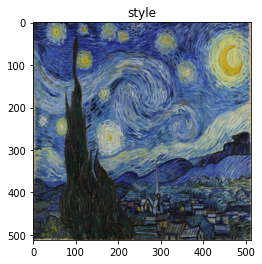

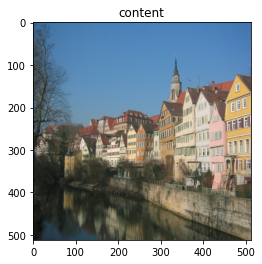

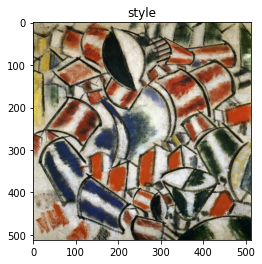

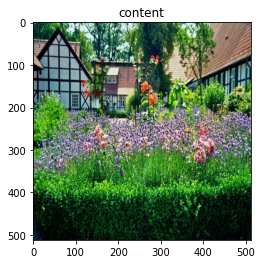

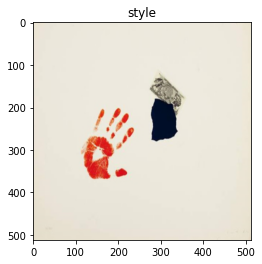

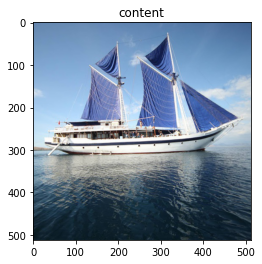

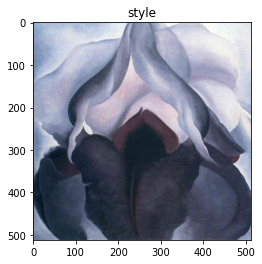

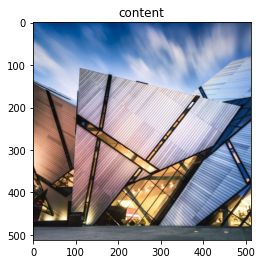

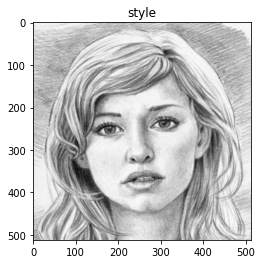

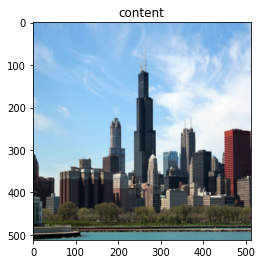

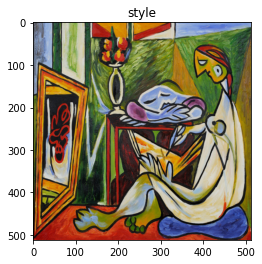

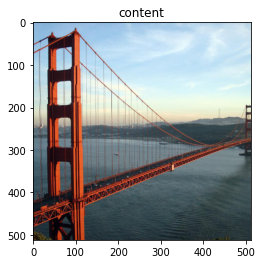

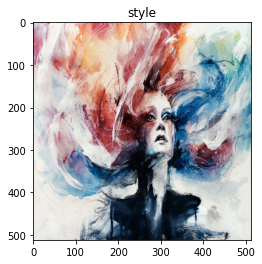

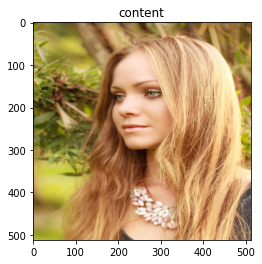

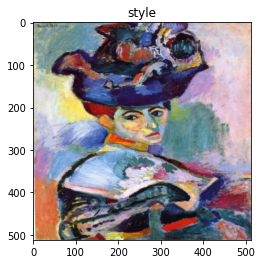

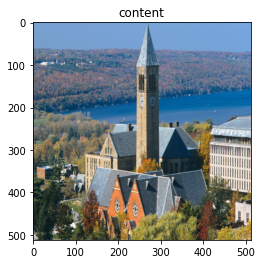

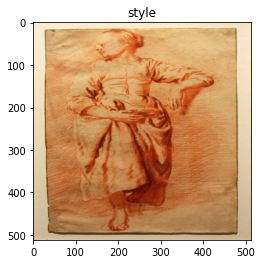

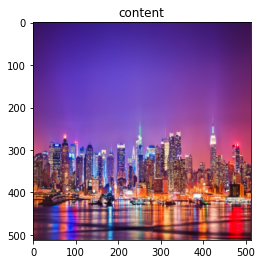

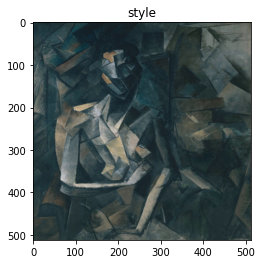

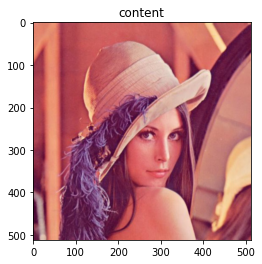

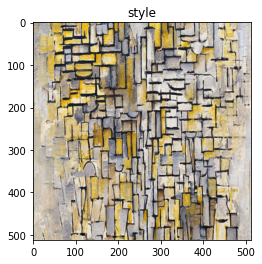

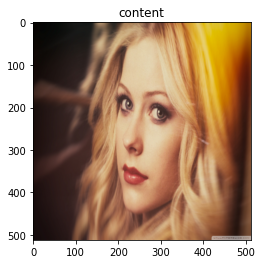

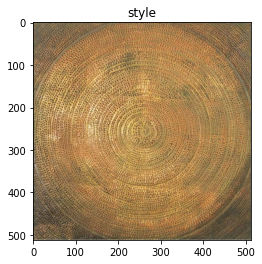

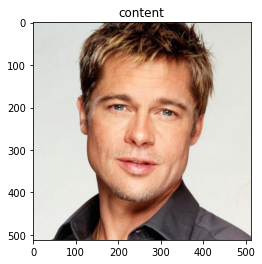

In [33]:
#shuffle datasets to obtain variance
#for i in range(0, len(all_img)):
#  im1, im2 = all_img.__getitem__(i)
#  imshow(im1, "style") 
#  imshow(im2, "content")

Instance Normalization normalizza l'input su un singolo stile specifico. Qui si propone la Adaptive Instance Normalization, dove stile e contenuto sono parametrici. Notare che non ci sono parametri learnable, la funzione stessa li computa dallo style input.

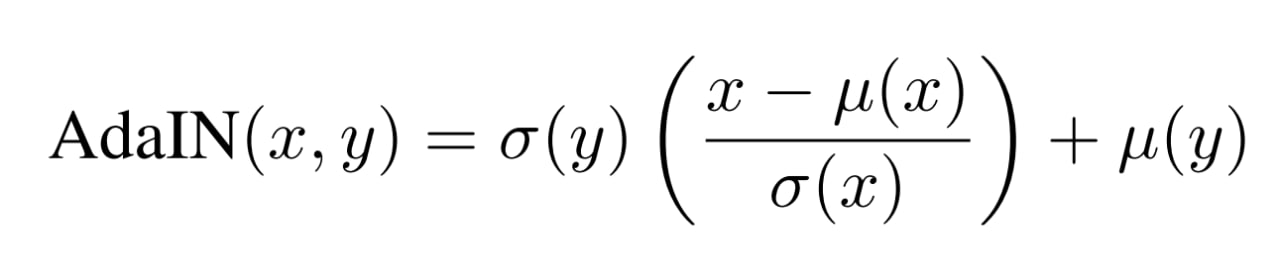

In [34]:
def calc_mean_std(input, eps=1e-5):
  #assert (len(input.size) == 4)

  batch_size, channels = input.shape[:2]

  reshaped = input.view(batch_size, channels, -1) # Reshape channel wise
  mean = torch.mean(reshaped, dim = 2).view(batch_size, channels, 1, 1) # Calculat mean and reshape
  std = torch.sqrt(torch.var(reshaped, dim=2)+eps).view(batch_size, channels, 1, 1) # Calculate variance, add epsilon (avoid 0 division),
                                                                                    # calculate std and reshape
  return mean, std

def ada_in(content_features, style_features):
  assert content_features.shape[:2] == style_features.shape[:2] # Only first two dim, such that different image sizes is possible

  style_mean, style_std = calc_mean_std(style_features)
  content_mean, content_std = calc_mean_std(content_features)

  output = style_std*((content_features - content_mean) / (content_std)) + style_mean


Content and Style Loss

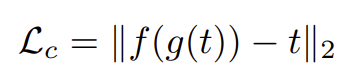

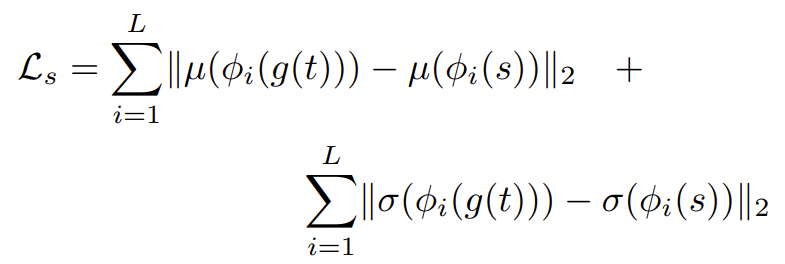

In [35]:
def content_loss(input, target): # Content loss is a simple MSE Loss
  assert (input.size() == target.size())
  assert (target.requires_grad is False)
  return F.mse_loss(input, target)
  
def style_loss(input, target):
  assert (input.size() == target.size())
  assert (target.requires_grad is False)

  input_mean, input_std = calc_mean_std(input)
  target_mean, target_std = calc_mean_std(target)

  return F.mse_loss(input_mean, target_mean) +  F.mse_loss(input_std, target_std)

**Implementazione della rete**
Econder + Decoder  


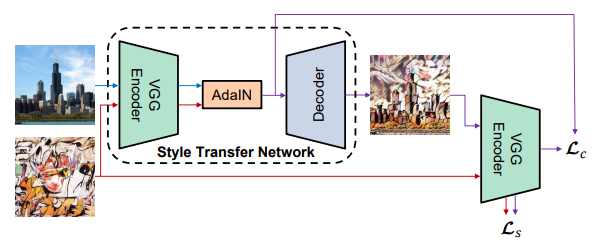

Ricordarsi inoltre la formula per gestire il tradeoff:
  T(c, s, α) = g((1 − α)f(c) + αAdaIN(f(c), f(s))) 

In [36]:
#Decoder: reversed vgg19 up to ReLU 4_1, last layer not activated
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.padding = nn.ReflectionPad2d(padding=1) # Using reflection padding as described in vgg19
    self.UpSample = nn.Upsample(scale_factor=2, mode="nearest") #all pooling layers replaced by nearest up-sampling to reduce checkerboard effect

    self.conv4_1 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=0)
    #UpSample
    
    self.conv3_4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=0)
    self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=0)
    self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=0)
    self.conv3_1 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=0)
    #UpSample

    self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0)
    self.conv2_1 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=0)
    #UpSample

    self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0)
    self.conv1_1 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=0)

  def forward(self, x):
    out = self.padding(x) #ReflectionPad --> Conv2d --> ReLU --[Se serve]--> UpSample
    out = self.conv4_1(out)
    out = self.UpSample(F.relu(out))

    out = F.relu(self.conv3_4(self.padding(out)))
    out = F.relu(self.conv3_3(self.padding(out)))
    out = F.relu(self.conv3_2(self.padding(out)))
    out = self.UpSample(F.relu(self.conv3_1(self.padding(out))))

    out = F.relu(self.conv2_2(self.padding(out)))
    out = self.UpSample(F.relu(self.conv2_1(self.padding(out))))

    out = F.relu(self.conv1_2(self.padding(out)))
    out = self.conv1_1(self.padding(out))
    return out

# A vgg19 Sequential which is used up to Relu 4.1. To note is that the
# first layer is a 3,3 convolution, different from a standard vgg19
class Encoder(nn.Module):
  def __init__(self, state_dict):
    super().__init__()
    self.vgg19 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=3, kernel_size=1), #first layer

        nn.ReflectionPad2d(padding=1),
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3),
        nn.ReLU(inplace=True), # relu 1_1

        nn.ReflectionPad2d(padding=1),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
        nn.ReLU(inplace=True), # relu 1_2

        nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True),

        nn.ReflectionPad2d(padding=1),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
        nn.ReLU(inplace=True),  # relu 2_1

        nn.ReflectionPad2d(padding=1),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
        nn.ReLU(inplace=True), # relu 2_2

        nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True),

        nn.ReflectionPad2d(padding=1),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
        nn.ReLU(inplace=True), # relu 3_1

        nn.ReflectionPad2d(padding=1),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3),
        nn.ReLU(inplace=True), # relu 3_2

        nn.ReflectionPad2d(padding=1),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3),
        nn.ReLU(inplace=True), # relu 3_3

        nn.ReflectionPad2d(padding=1),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3),
        nn.ReLU(inplace=True), # relu 3_4

        nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True),

        nn.ReflectionPad2d(padding=1),
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
        nn.ReLU(inplace=True), # relu 4_1 ===> Output layer of the decoder

        nn.ReflectionPad2d(padding=1),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3),
        nn.ReLU(inplace=True), # relu 4_2

        nn.ReflectionPad2d(padding=1),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3),
        nn.ReLU(inplace=True), # relu 4_3

        nn.ReflectionPad2d(padding=1),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3),
        nn.ReLU(inplace=True), # relu 4_4

        nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True),

        nn.ReflectionPad2d(padding=1),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3),
        nn.ReLU(inplace=True), # relu 5_1

        nn.ReflectionPad2d(padding=1),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3),
        nn.ReLU(inplace=True), # relu 5_2

        nn.ReflectionPad2d(padding=1),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3),
        nn.ReLU(inplace=True), # relu 5_3

        nn.ReflectionPad2d(padding=1),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3),
        nn.ReLU(inplace=True) # relu 5_4
        ).to(device)

    self.vgg19.load_state_dict(state_dict)

    encoder_children = list(self.vgg19.children())
    self.encoder_layers = nn.ModuleList([nn.Sequential(*encoder_children[:4]), # Up to Relu 1.1
                                      nn.Sequential(*encoder_children[4:11]), # Up to Relu 2.1
                                      nn.Sequential(*encoder_children[11:18]), # Up to Relu 3.1
                                      nn.Sequential(*encoder_children[18:31]), # Up to Relu 4.1, also the
                                      ])                                       # input for the decoder

  def forward(self, x, intermediates=False): # if training use intermediates = True, to get the output of
    states = []                            # all the encoder layers to calculate the style loss
    for i in range(len(self.encoder_layers)):
      x = self.encoder_layers[i](x)

      if intermediates:       # All intermediate states get saved in states
        states.append(x)
    if intermediates:
        return states #ritorna un vettore con tutti gli stadi intermedi
    return x


class Net(nn.Module):
  def __init__(self, enc_state_dict, # The state dict of the pretrained vgg19
              learning_rate=1e-4, learning_rate_decay=5e-5, gamma=2.0, 
              train=True, # Wether or not network is training
              load_fromstate=False, # Load from checkpoint?
              load_path=None # Path to load checkpoint
              ):
    super().__init__()

    if load_fromstate and not os.path.isfile(load_path):
      raise ValueError("Checkpoint file not found")

    self.learning_rate = learning_rate
    self.learning_rate_decay = learning_rate_decay# Decay parameter for the learning rate
    self.gamma = gamma # Controls importance of StyleLoss vs ContentLoss, Loss = gamma*StyleLoss + ContentLoss
    self.iters=0

    self.train = train

    self.encoder = Encoder(enc_state_dict)
    self.decoder = Decoder().to(device) #il to device dell'encoder sta nel sequential del modulo
    self.optimiser = optim.Adam(self.decoder.parameters(), lr = self.learning_rate)

    if load_fromstate: #TUTTA STA ROBA DEL LAOD FROM STATE E TRAIN PENSO LA TOGLIERO
      state = torch.load(load_path)
      self.decoder.load_state_dict(state["Decoder"])
      self.optimiser.load_state_dict(state["Optimiser"])
      self.iters = state["iters"]

  def set_train(self, boolean): # Change state of network
    assert type(boolean) == bool
    self.train = boolean

  def adjust_learning_rate(self, optimiser, iters): # Simple learning rate decay
    lr = self.learning_rate / (1.0 + self.learning_rate_decay * iters)
    for param_group in optimiser.param_groups:
        param_group['lr'] = lr

  def forward(self, style, content, alpha=1.0): #alpha == balance between content n style
    assert 0 <= alpha <= 1

    style_feats = self.encoder(style, intermediates = True) #layers_style = self.encoder(style, self.train) # if train: returns all states
    content_feat = self.encoder(content)
    t = (alpha*ada_in(content_feat, style_feats[-1])) + (1 - alpha)*content_feat

    g_t = self.decoder(t)
    g_t_features = self.encoder(t, True)

    #computing losses

    loss_c = content_loss(g_t_features[-1], content_feat)
    loss_s = style_loss(g_t_features[0], style_feats[0])
    for i in range(1, 4):
      loss_s += style_loss(g_t_features[i], style_feats[i])

    total_loss = gamma*loss_s + loss_c

    return total_loss, loss_s, loss_c

In [37]:
# Simple save 
def save_state(decoder, optimiser, iters, run_dir):
  name = "StyleTransfer Checkpoint Iter: {}.tar".format(iters)
  torch.save({"Decoder" : decoder,
              "Optimiser" : optimiser,
              "iters": iters
              }, os.path.join(path, name))
  print("Saved : {} succesfully".format(name))

In [38]:
learning_rate = 1e-4
learning_rate_decay = 5e-5

def adjust_learning_rate(optimizer, iteration_count):
    """Imitating the original implementation"""
    lr = learning_rate / (1.0 + learning_rate_decay * iteration_count)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def training_loop(network, # StyleTransferNetwork
                  dataloader_comb, # DataLoader
                  n_epochs, # Number of Epochs
                  run_dir # Directory in which the checkpoints and tensorboard files are saved
                  ):
  

  writer = SummaryWriter(os.path.join(path, run_dir))
  # Fixed images to compare over time
  fixed_batch_style, fixed_batch_content = all_img[0]
  fixed_batch_style, fixed_batch_content =  fixed_batch_style.unsqueeze(0).to(device), fixed_batch_content.unsqueeze(0).to(device) # Move images to device

  writer.add_image("Style", torchvision.utils.make_grid(fixed_batch_style))
  writer.add_image("Content", torchvision.utils.make_grid(fixed_batch_content))

  iters = network.iters

  for epoch in range(1, n_epochs+1):
    tqdm_object = tqdm(dataloader_comb, total=len(dataloader_comb))

    for style_imgs, content_imgs in tqdm_object:
      network.adjust_learning_rate(network.optimiser, iters)
      style_imgs = style_imgs.to(device)
      content_imgs = content_imgs.to(device)

      loss_comb, content_loss, style_loss = network(style_imgs, content_imgs)

      network.optimiser.zero_grad()
      loss_comb.backward()
      network.optimiser.step()

      # Update status bar, add Loss, add Images
      tqdm_object.set_postfix_str("Combined Loss: {:.3f}, Style Loss: {:.3f}, Content Loss: {:.3f}".format(
                                  loss_comb.item()*100, style_loss.item()*100, content_loss.item()*100))
    
      if iters % 25 == 0:
        writer.add_scalar("Combined Loss", loss_comb*1000, iters)
        writer.add_scalar("Style Loss", style_loss*1000, iters)
        writer.add_scalar("Content Loss", content_loss*1000, iters)

      if (iters+1) % 2000 == 1:
        with torch.no_grad():
          network.set_train(False)
          images = network(fixed_batch_style, fixed_batch_content)
          img_grid = torchvision.utils.make_grid(images)
          writer.add_image("Progress Iter: {}".format(iters), img_grid)
          network.set_train(True)

      if (iters+1) % 4000 == 1:
          save_state(network.decoder.state_dict(), network.optimiser.state_dict(), iters, run_dir)
          writer.close()
          writer = SummaryWriter(os.path.join(path, run_dir))

      iters += 1

In [39]:
dataloader_comb = DataLoader(all_img, batch_size=5, shuffle=True, num_workers=0, drop_last=True)
gamma = torch.tensor([2]).to(device) # Style weight

n_epochs = 5
run_dir = "../runs/Run 1" # Change if you want to save the checkpoints/tensorboard files in a different directory

state_encoder = torch.load("/content/data/MyDrive/vgg_normalised.pth")
network = Net(state_encoder, learning_rate, learning_rate_decay, gamma, train=True, load_fromstate=False, load_path=os.path.join(path, "StyleTransfer Checkpoint Iter: 120000.tar"))

In [40]:
training_loop(network, dataloader_comb, n_epochs, run_dir)

  0%|          | 0/2 [00:00<?, ?it/s]

TypeError: ignored